# Text Classification

## Introduction

This notebook serves as a guide for detecting biases in text classification tasks.

The chosen model here is Bidirectional Encoder Representations from Transformers (BERT) and the dataset used is the [AG News dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset).

## Imports

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.9 MB/s 
     |████████████████████████████████| 7.6 MB 48.8 MB/s 
     |████████████████████████████████| 182 kB 59.3 MB/s 


In [ ]:
from transformers import AutoTokenizer, BertForSequenceClassification
import numpy as np
import pandas as pd
import torch
from torch import tensor
from sklearn import metrics
import matplotlib.pyplot as plt

## Model Initialization

A Bidirectional Encoder Representations from Transformers (BERT) is fine-tuned using [lucasresck/bert-base-cased-ag-news](https://huggingface.co/lucasresck/bert-base-cased-ag-news) from HuggingFace. This is the base AG News dataset.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('lucasresck/bert-base-cased-ag-news')
model = BertForSequenceClassification.from_pretrained('lucasresck/bert-base-cased-ag-news')

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/857 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/configuration_utils.py:369: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [ ]:
def infer(text, actual):
  encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
  output = model(**encoded_input)
  return output.logits.detach()

### Import Dataset

The dataset used in this example is based on the AG News dataset, passed through our dataset generator (in the `Splitting_Data.ipynb` Colab notebook) to create variations with different identity terms. The process for generating the dataset is explained in much more detail there. 

There are 2 `.csv` files you can use here:<br>
<b>'Expanded_Identities_Dataset.csv'</b> is the AG News dataset with the added identies.<br>
<b>'Expanded_Identities_Inferred.csv'</b> is the same dataset but with additonal columns including the inferrence results from using our BERT model on the dataset. This is included since it can take up to 20 minutes to run inferrence on the whole dataset, so using this file and running the second code block can be used as an alternative if you don't have time to wait for it to run.

In [ ]:
# Run this to import original dataset
expanded_identities_df = pd.read_csv('Expanded_Identities_Dataset.csv')

In [ ]:
# Run these to import inferred dataset
expanded_identities_df = pd.read_csv('Expanded_Identities_Inferred.csv')
expanded_identities_df['model_output'] = expanded_identities_df['model_output'].apply(lambda x: eval(x)[0].tolist())
expanded_identities_df['model_argmax'] = expanded_identities_df['model_output'].apply(np.argmax)
# it is important to run this line too to convert the model_output from a string to a list

### Run inference on Dataset (optional)

**Note: this can take up to 20 minutes to run, so to test quickly, use a subset of the whole dataframe or upload Expanded_Identities_Inferred.csv as explained above instead**

In [ ]:
expanded_identities_df['model_output'] = expanded_identities_df.apply(lambda row: infer(row.text, row.label), axis = 1)
expanded_identities_df['model_output'] = expanded_identities_df['model_output'].apply(lambda x: x.tolist()[0])
expanded_identities_df['model_argmax'] = expanded_identities_df['model_output'].apply(np.argmax)
expanded_identities_df['correct'] = expanded_identities_df['model_argmax'] == expanded_identities_df['label']
expanded_identities_df['correct'] = expanded_identities_df['correct'].astype(int)

In [ ]:
expanded_identities_df.head()

,text,label,label_name,Words Per Tweet,Gender,Sexual Orientation,Religion,Race/Ethnicity,Disability,model_output,model_argmax,correct
0,Mars Rovers Relay Images Through Mars Express ...,3,Sci/Tech,52,NaN,NaN,NaN,White,NaN,"[-1.1612000465393066, -2.397599935531616, -2.6...",3,1
1,mars rovers relay images through mars express ...,3,Sci/Tech,52,NaN,NaN,NaN,Black,NaN,"[-0.7139999866485596, -2.6201000213623047, -2....",3,1
2,mars rovers relay images through mars express ...,3,Sci/Tech,52,NaN,NaN,NaN,Asian,NaN,"[-1.1658999919891357, -2.634700059890747, -2.4...",3,1
3,mars rovers relay images through mars express ...,3,Sci/Tech,52,NaN,NaN,NaN,Latino,NaN,"[-1.7628999948501587, -2.3217999935150146, -2....",3,1
4,mars rovers relay images through mars express ...,3,Sci/Tech,52,NaN,NaN,NaN,Other Races,NaN,"[-2.2172000408172607, -2.09879994392395, -2.15...",3,1


### Analysis Examples

For text classification, we included analysis of average correct/incorrect predictions, the probabilites required to calculate demographic parity, equalized odds, and equality of opportunity. Gender and Race are the biases shown here in the examples, but the same process can be applied to other bias groups, such as Sexual Orientation, Disability, and Religion. Further background on the metrics and their interpretations is included in the report.

#### Gender Bias Analysis

The gender-based text terms are extracted and compared.

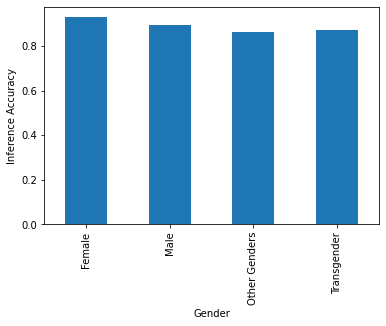

In [ ]:
gender_df = expanded_identities_df[~expanded_identities_df['Gender'].isna()]
gender_df = gender_df[~(gender_df['Gender'] == "Male Female")]
gender_grouped_df = gender_df.groupby('Gender').mean()['correct']
gender_grouped_df.plot(kind='bar', ylabel = 'Inference Accuracy')

In [ ]:
def create_agg_df(df, bias):
  classes = df.groupby('label_name').mean()['label'].reset_index()
  agg_df = pd.DataFrame(columns=['class', 'prob', bias])
  for label_name, label_val in classes.values:
    label = int(label_val)
    subgroup_df = df.copy()
    subgroup_df['class'] = (df['label_name'] == label_name).astype(int)
    subgroup_df['prob'] = df['model_output'].apply(lambda x: x[label])
    agg_df = pd.concat([agg_df, subgroup_df[['class', 'prob', bias]]])
  return agg_df

def plot_hist(df, title, legend, groupby='class'):
  fig, ax = plt.subplots(1,1, figsize=(8,6))
  df.groupby(groupby).prob.hist(alpha=0.4, ax=ax)
  ax.legend(legend)
  ax.set_ylabel('Count')
  ax.set_xlabel('Model Output (Score)')
  ax.set_title(title)

def get_probabilities_for(df, subgroup, bias):
  probs = {'Demographic Parity': [], 'Equalized Odds': [], 'Equal Opportunity': []}
  subgroup_df = df[df[bias] == subgroup]
  classes = subgroup_df.groupby('label_name').mean()['label'].reset_index()
  for label_name, label_val in classes.values:
    probs['Demographic Parity'] += [len(subgroup_df[subgroup_df['model_argmax'] == label_val].values) \
                                      / len(subgroup_df.values)]
    temp_df = subgroup_df[subgroup_df['label'] == label_val]
    probs['Equal Opportunity'] += [len(temp_df[temp_df['model_argmax'] == label_val].values) \
                                      / len(temp_df.values)]
    temp_df = subgroup_df[~(subgroup_df['label'] == label_val)]
    probs['Equalized Odds'] += [len(temp_df[~(temp_df['model_argmax'] == label_val)].values) \
                                    / len(temp_df.values)]
  for k,v in probs.items():
    probs[k] = np.mean(v)
  return probs

def graph_probabilites(bias_df, bias):
  sub_cats = bias_df.groupby(bias).mean().reset_index()[bias]
  probabilities_dict = {}
  metrics = ['Demographic Parity', 'Equal Opportunity', 'Equalized Odds']
  prob_df = pd.DataFrame(columns=[bias, *metrics])
  for sub_cat in sub_cats.values:
    prob = get_probabilities_for(bias_df, sub_cat, bias)
    probabilities_dict[sub_cat] = prob
    prob_df.loc[len(prob_df.index)] = [sub_cat, *prob.values()]

  for metric in metrics:
    # min_val = prob_df[metric].min()
    # prob_df[metric] -= min_val
    prob_df.plot(kind='bar', x=bias, y=metric, ylabel = f'{metric}',\
                  title = metric, ylim=(prob_df[metric].min(), prob_df[metric].max()+0.02))
  return prob_df

In [ ]:
def plot_histograms(bias_df, bias):
  print("\n\n")
  print("=====================================================================================================")
  print("=========== HISTOGRAMS OF SCORES FOR CORRECT AND INCORRECT CLASSFICATIONS, PER SUBGROUP =============")
  print("=====================================================================================================")
  print("\n\n")

  agg_df = create_agg_df(bias_df, bias)
  plot_hist(agg_df, "Background", ["Incorrect", "Correct"])

  sub_cats = bias_df.groupby(bias).mean().reset_index()[bias]
  for sub_cat in sub_cats.values:
    curr_df = create_agg_df(bias_df, bias)
    curr_df = curr_df[curr_df[bias] == sub_cat]
    plot_hist(curr_df, sub_cat, ["Incorrect", "Correct"])

  plt.show()

  print("\n\n")
  print("=====================================================================================================")
  print("======================== COMPARISON OF SCORES FOR CORRECT CLASSFICATIONS ===========================")
  print("=====================================================================================================")
  print("\n\n")

  for sub_cat in sub_cats.values:
    curr_df = create_agg_df(bias_df, bias)
    curr_df = curr_df[curr_df["class"] == 1]
    curr_df['is_group'] = (curr_df[bias] == sub_cat).astype(int)
    plot_hist(curr_df[['prob', 'is_group']], sub_cat, ["Background", sub_cat], groupby="is_group")

  plt.show()

  print("\n\n")
  print("=====================================================================================================")
  print("======================== COMPARISON OF SCORES FOR INCORRECT CLASSFICATIONS ===========================")
  print("=====================================================================================================")
  print("\n\n")

  for sub_cat in sub_cats.values:
    curr_df = create_agg_df(bias_df, bias)
    curr_df = curr_df[curr_df["class"] == 0]
    curr_df['is_group'] = (curr_df[bias] == sub_cat).astype(int)
    plot_hist(curr_df[['prob', 'is_group']], sub_cat, ["Background", sub_cat], groupby="is_group")

  plt.show()




=========== HISTOGRAMS OF SCORES FOR CORRECT AND INCORRECT CLASSFICATIONS, PER SUBGROUP =============





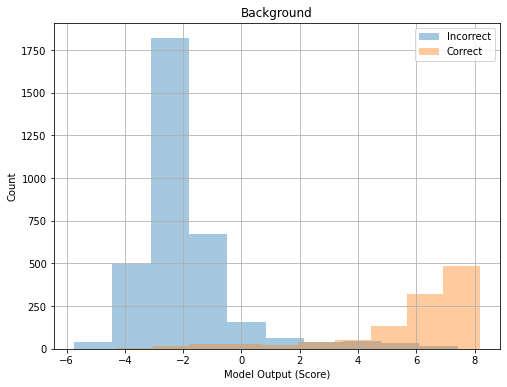

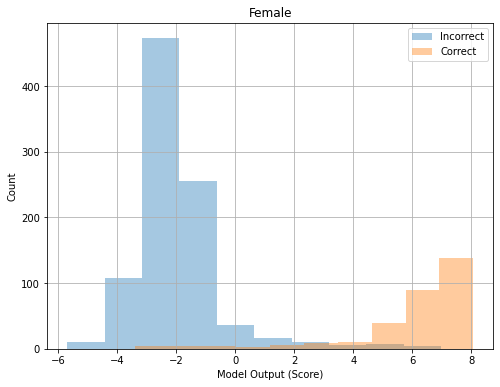

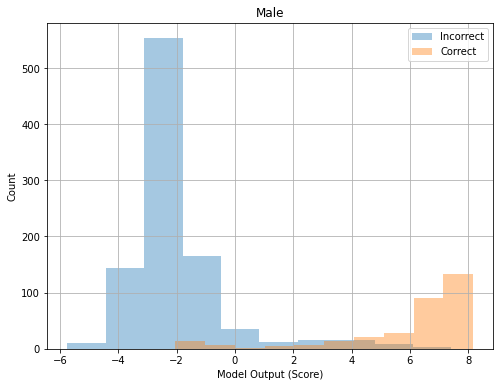

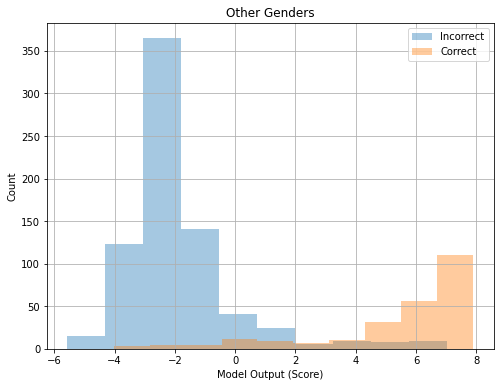

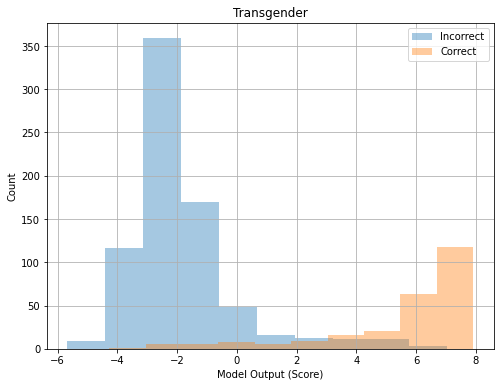




======================== COMPARISON OF SCORES FOR CORRECT CLASSFICATIONS ===========================





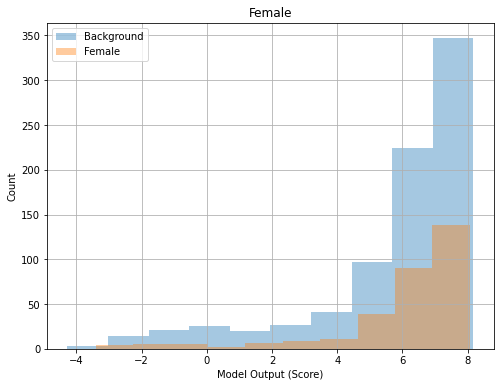

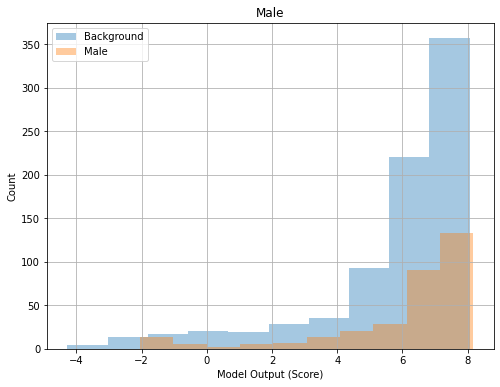

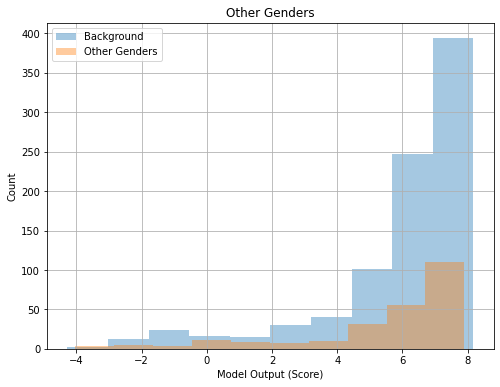

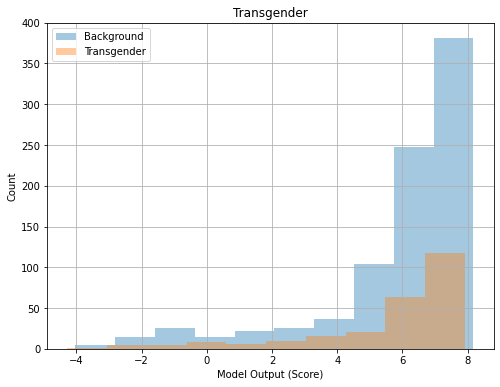




======================== COMPARISON OF SCORES FOR INCORRECT CLASSFICATIONS ===========================





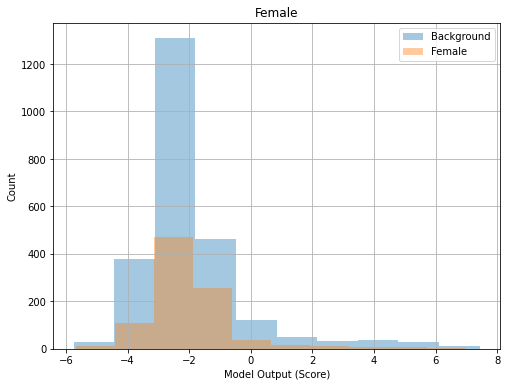

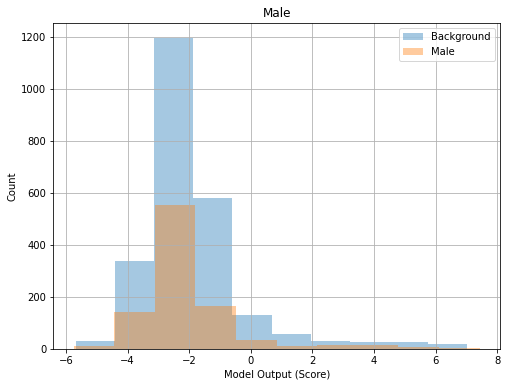

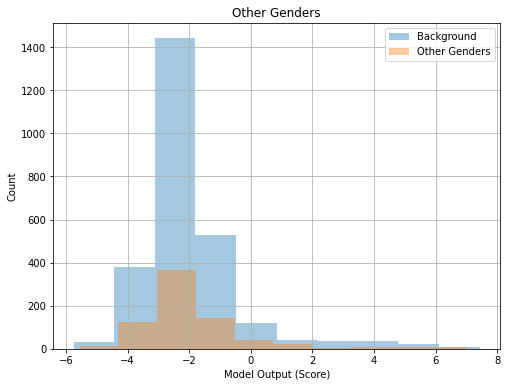

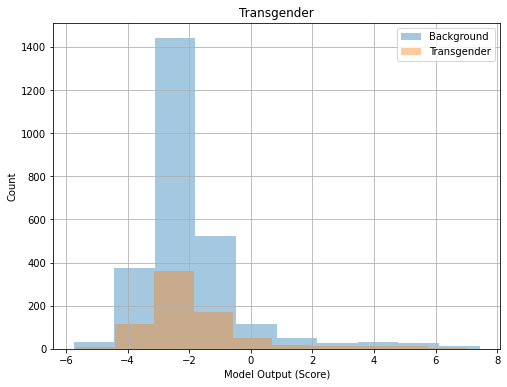

In [ ]:
plot_histograms(gender_df, "Gender")

,Gender,Demographic Parity,Equal Opportunity,Equalized Odds
0,Female,0.25,0.973456,0.870029
1,Male,0.25,0.962804,0.861641
2,Other Genders,0.25,0.954940,0.812633
3,Transgender,0.25,0.957467,0.826682


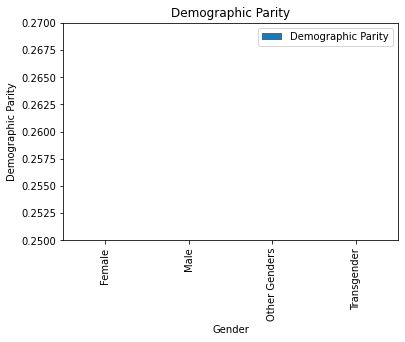

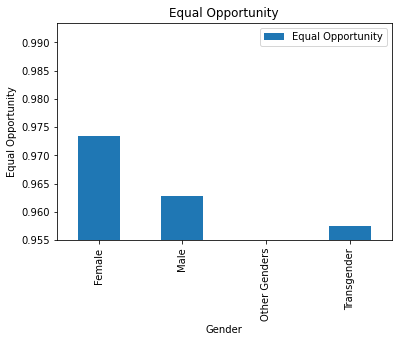

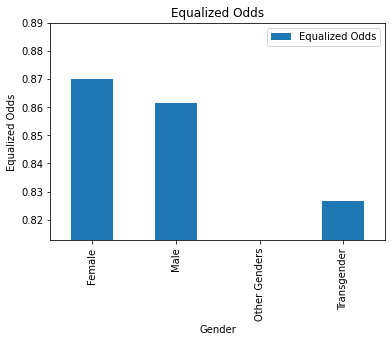

In [ ]:
graph_probabilites(gender_df, "Gender")


#### Racial Bias Analysis

The race-based text terms are extracted and compared.

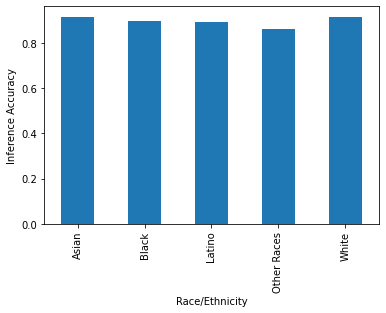

In [ ]:
race_df = expanded_identities_df[~expanded_identities_df['Race/Ethnicity'].isna()]
race_df = race_df[~(race_df['Race/Ethnicity'] == "Black White")]
race_grouped_df = race_df.groupby('Race/Ethnicity').mean()['correct']
race_grouped_df.plot(kind='bar', ylabel = 'Inference Accuracy')




=========== HISTOGRAMS OF SCORES FOR CORRECT AND INCORRECT CLASSFICATIONS, PER SUBGROUP =============





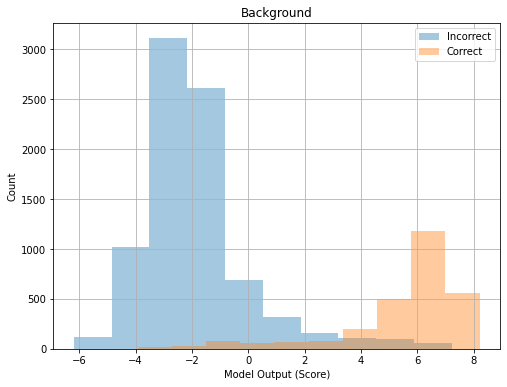

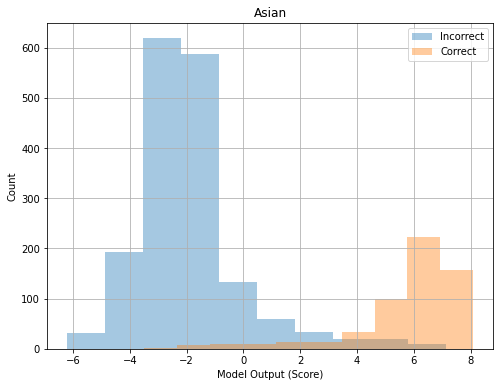

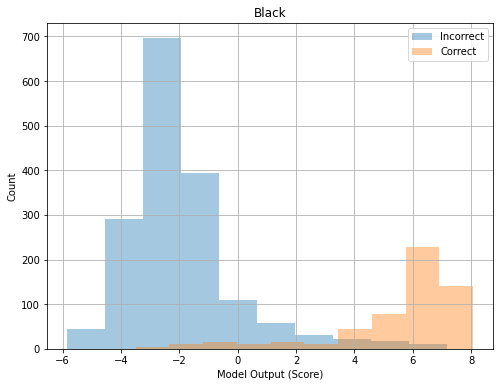

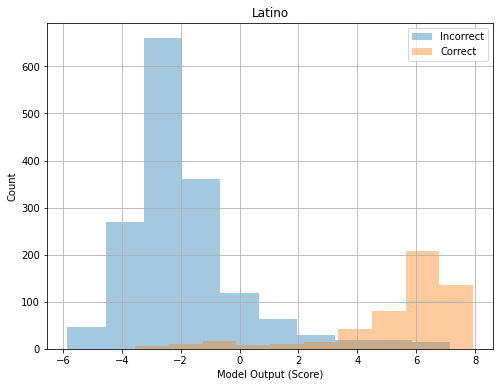

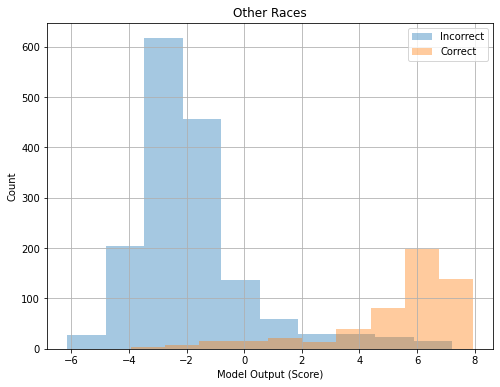

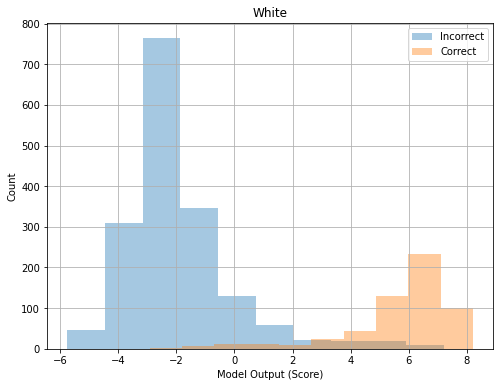




======================== COMPARISON OF SCORES FOR CORRECT CLASSFICATIONS ===========================





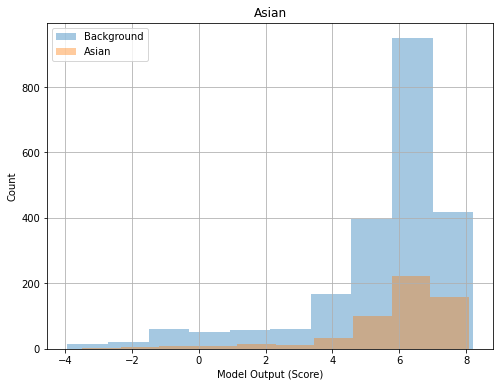

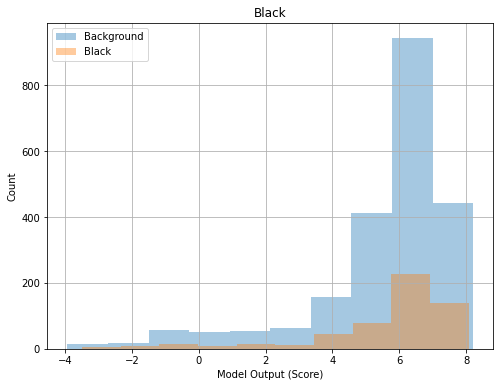

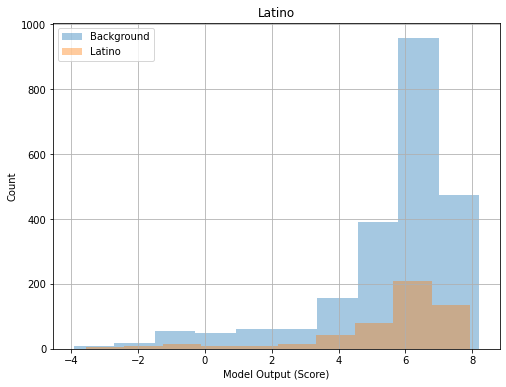

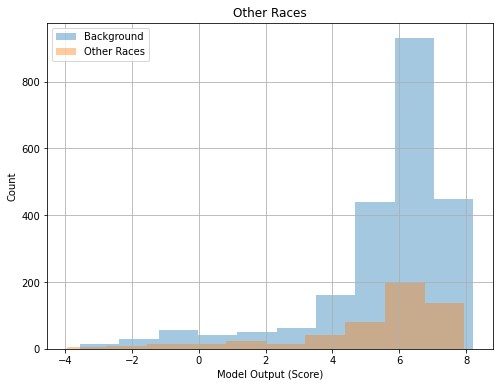

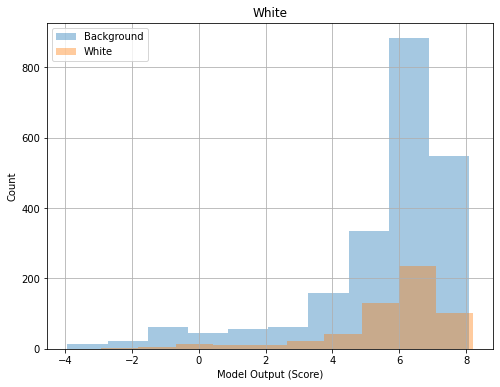




======================== COMPARISON OF SCORES FOR INCORRECT CLASSFICATIONS ===========================





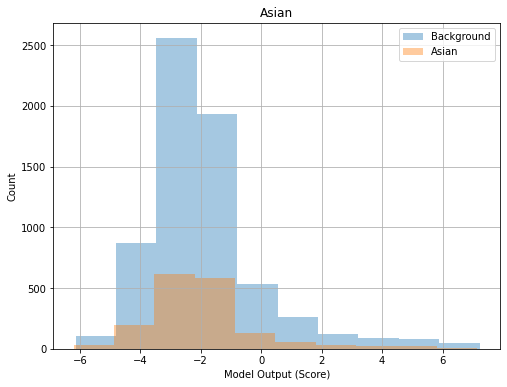

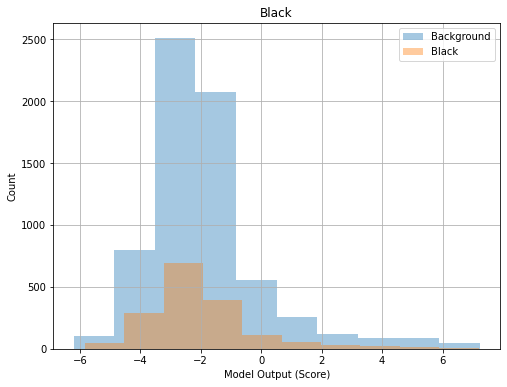

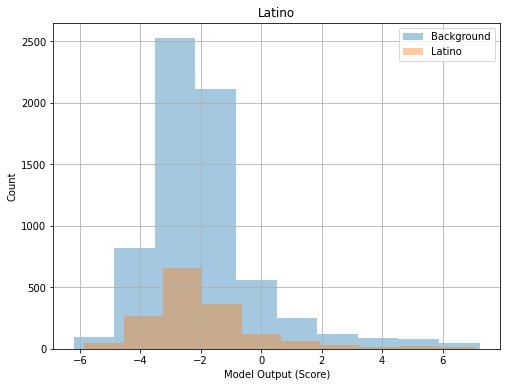

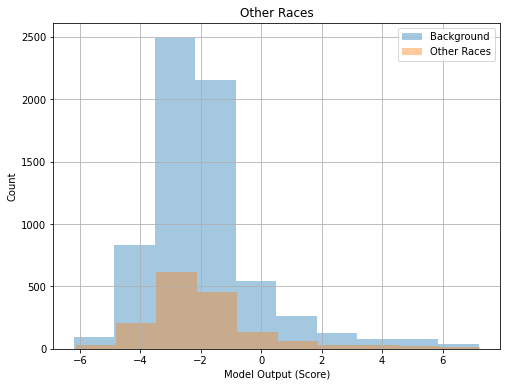

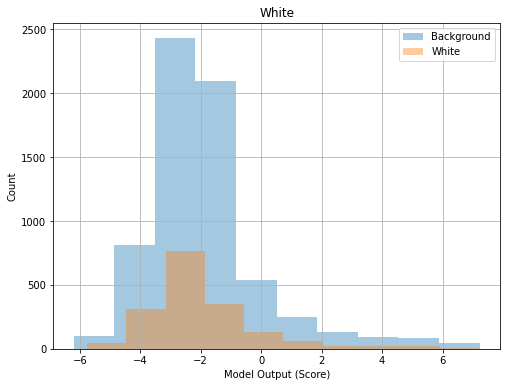

In [ ]:
plot_histograms(race_df, "Race/Ethnicity")

,Race/Ethnicity,Demographic Parity,Equal Opportunity,Equalized Odds
0,Asian,0.25,0.969488,0.912433
1,Black,0.25,0.965564,0.907761
2,Latino,0.25,0.963147,0.906601
3,Other Races,0.25,0.953529,0.886353
4,White,0.25,0.971169,0.921774


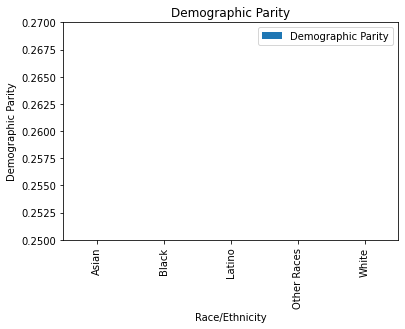

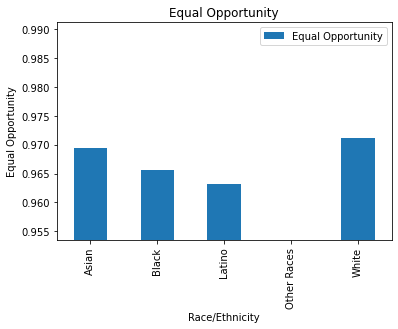

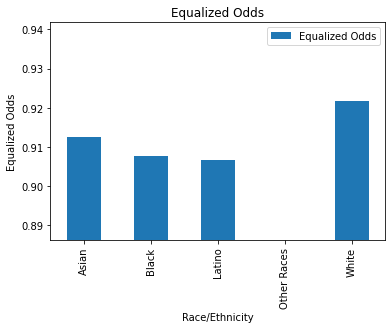

In [ ]:
graph_probabilites(race_df, "Race/Ethnicity")

### Potential Next Steps

Included here is some starting code for potential additonal metrics that can be further explored and potentially included, such as binary results (TPR, FPR, etc.) and AUC-ROC curves.

In [ ]:
print(metrics.classification_report(gender_df['label'],gender_df['model_argmax']))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       501
           1       0.94      0.95      0.94       426
           2       0.71      0.70      0.70       100
           3       0.69      0.86      0.77       101

    accuracy                           0.89      1128
   macro avg       0.82      0.85      0.83      1128
weighted avg       0.90      0.89      0.89      1128



In [ ]:
def plot_auc(truth, predicted, group, auc_type):
  fpr, tpr, _ = metrics.roc_curve(truth,  predicted)
  auc = metrics.roc_auc_score(truth, predicted)
  plt.plot(fpr,tpr,label="AUC="+str(auc))
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title(auc_type+" AUC (Subgroup = "+group+")")
  plt.legend(loc=4)
  plt.show()

def calculate_metrics(df):
  true, pred = (df['label'],df['model_argmax'])
  # plot_auc(true, pred, "test", "lol")
  conf_matrices = metrics.confusion_matrix(true, pred)
  p_s = metrics.precision_score(true, pred, average='micro')
  print(conf_matrices)
  print(p_s)

In [ ]:
calculate_metrics(gender_df)

[[444  18  15  24]
 [  4 405   9   8]
 [ 18   5  70   7]
 [  4   5   5  87]]
0.8918439716312057
